## Data Exploration, Feature Engineering and Experimentation

Now we're to the fun part - the Data Science. Now that the data engineers have cleaned and loaded the data to the `trips` table, we can begin our model development. For this, we will leverage Snowpark to do the **feature preparation and exploratory analysis**.   This dataset is initially ~100 million rows and is likely too large to fit into memory on our local machine or even a reasonable sized single VM in the cloud. The Snowpark Python client-side Dataframe API 
allows us to push-down most of the computation for preparation and feature engineering to Snowpark. For security and goverance reasons we can read data into memory for model training and inference but no intermediate data products can be stored outside of Snowflake.  

Input: Data in `trips` table.   
Output: Feature engineering logic.  Train function.  Predict function.

For this demo we will rewind in time and assume that it is January 1, 2020.  With the bulk ingest we have 92M records from 2013 to January 2020.

### 1. Load the Credentials


In [1]:
from dags.snowpark_connection import snowpark_connect
session, state_dict = snowpark_connect()

### 2. Exploratory Data Analysis

In [2]:
import snowflake.snowpark as snp
from snowflake.snowpark import functions as F
from snowflake.snowpark import types as T

import pandas as pd
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error

#import logging
#logging.basicConfig(level=logging.WARN)
#logging.getLogger().setLevel(logging.DEBUG)

/home/studio-lab-user/.conda/envs/snowpark_0110/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
state_dict['trips_table_name']='TRIPS'

In [4]:
session.table(state_dict['trips_table_name']).select(F.min('STARTTIME'), F.max('STARTTIME')).show()
session.table(state_dict['trips_table_name']).count()

-----------------------------------------------------
|"MIN(""STARTTIME"")"  |"MAX(""STARTTIME"")"        |
-----------------------------------------------------
|2013-06-01 00:00:01   |2019-12-31 23:59:55.296000  |
-----------------------------------------------------



91890993

This is too large to fit in memory on my local system.  Lets summarize trips to daily resolution and inspect the first ten rows

In [5]:
snowdf = session.table(state_dict['trips_table_name'])
snowdf.with_column('DATE', F.to_date('STARTTIME')).group_by('DATE').count().sort('DATE').show(10)

------------------------
|"DATE"      |"COUNT"  |
------------------------
|2013-06-01  |8721     |
|2013-06-02  |15971    |
|2013-06-03  |7598     |
|2013-06-04  |15782    |
|2013-06-05  |15690    |
|2013-06-06  |12420    |
|2013-06-07  |1226     |
|2013-06-08  |18007    |
|2013-06-09  |21034    |
|2013-06-10  |3897     |
------------------------



Once we aggregate the data at the day level we have a small enough dataset to fit in memory.  But we may want to provide a more granular time series (ie. hour or minute-level) or perhaps our data will grow considerably over time.  In either case we can't rely on in-memory computation and will want to push-down as much computation as possible to Snowflake.  
  
For exploration purposes we can see a good daily and annual seasonality in the historical data.

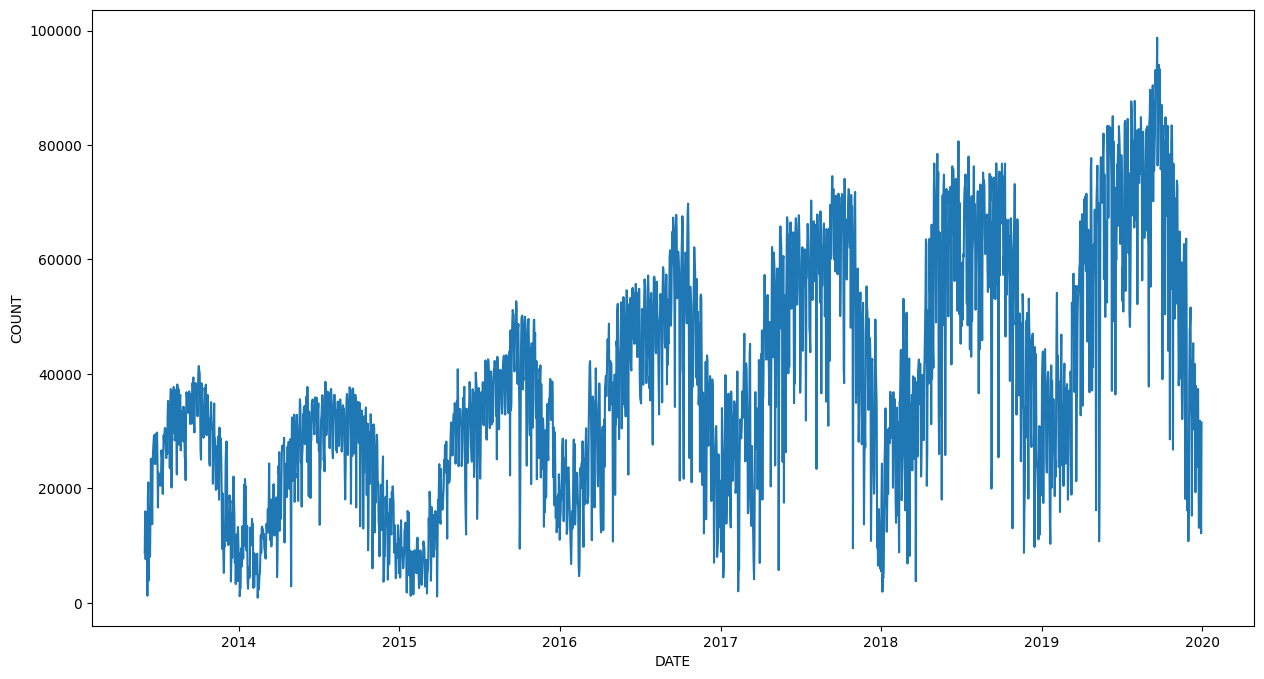

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

df = snowdf.with_column("date", F.to_date("STARTTIME")).group_by("date").count().sort("date").to_pandas()
df.head()

plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='DATE', y='COUNT', data=df)

We may not be able to get a good model that can predict across ALL stations.  Lets start with just the busiest station(s).

In [7]:
snowdf.filter(F.col('START_STATION_ID').is_not_null()) \
      .group_by('START_STATION_ID') \
      .count() \
      .sort('COUNT', ascending=False).show()

--------------------------------
|"START_STATION_ID"  |"COUNT"  |
--------------------------------
|519                 |870948   |
|497                 |663695   |
|435                 |626677   |
|402                 |591990   |
|426                 |590346   |
|285                 |559365   |
|293                 |538588   |
|490                 |523658   |
|459                 |496522   |
|477                 |496198   |
--------------------------------



Initially we will build with the busiest station "Central Park S & 6 Ave" which is STATION_ID=519.  Later we will see how Snowpark Python allows us to tap into the powerful horizontally, scalable compute engine to parallelize this across all stations.

In [8]:
top_stations = snowdf.filter(F.col('START_STATION_ID').is_not_null()) \
                                                   .groupBy('START_STATION_ID') \
                                                   .count() \
                                                   .sort('COUNT', ascending=False) \
                                                   .to_pandas()['START_STATION_ID'].values.tolist()
top_stations[0:10]

['519', '497', '435', '402', '426', '285', '293', '490', '459', '477']

In [9]:
df = snowdf.filter(F.col('START_STATION_ID') == top_stations[0]) \
      .withColumn('DATE', 
                  F.call_builtin('DATE_TRUNC', ('DAY', F.col('STARTTIME')))) \
      .groupBy('DATE') \
      .count() \
      .sort('DATE').to_pandas()

df.head()

,DATE,COUNT
0,2013-06-01,33
1,2013-06-02,46
2,2013-06-03,41
3,2013-06-04,72
4,2013-06-05,114


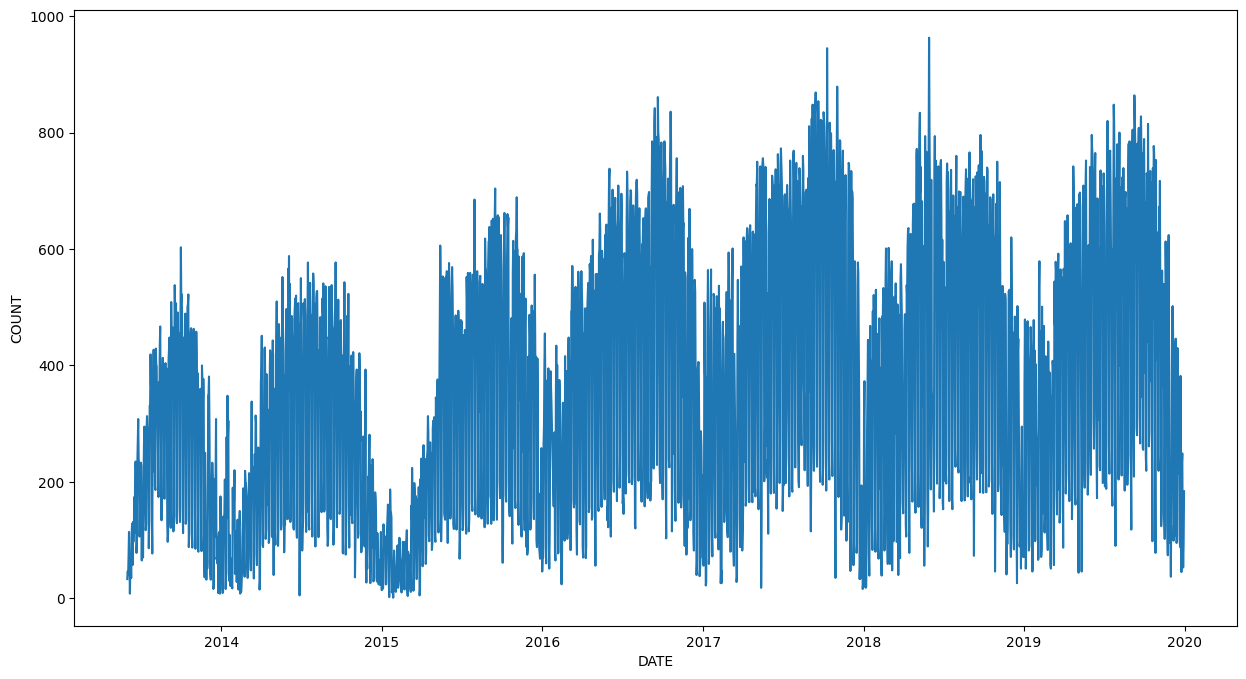

In [10]:
plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='DATE', y='COUNT', data=df)

We can see what looks like daily, weekly and annual periodicity as well as a slight upward trend over years. To start building the features for a regression model we might start with lag features. We can use autocorrelation to confirm our initial guess.

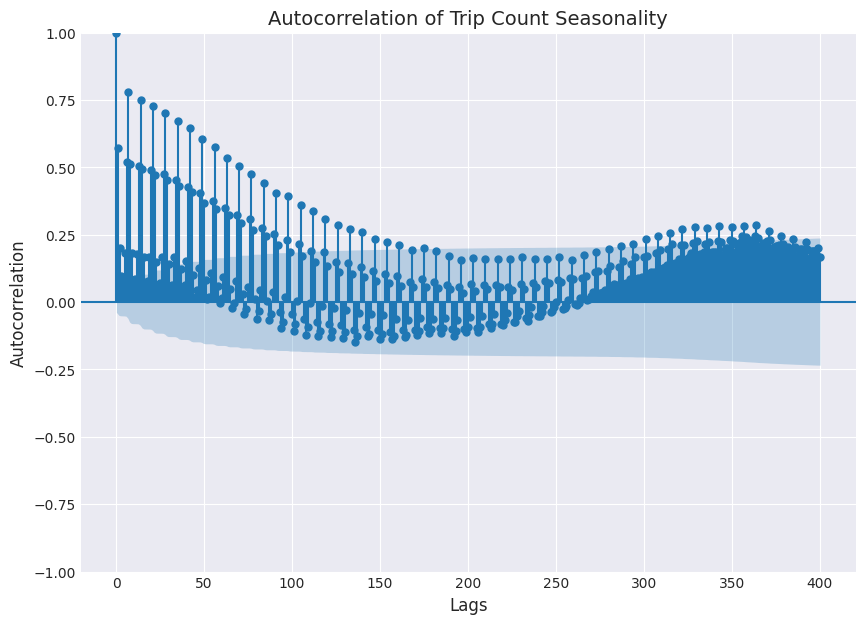

In [11]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rc("figure", figsize=(10, 7))
plot_acf(df['COUNT'], lags=400)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of Trip Count Seasonality', fontsize=14)
plt.show()

We can definitely see the strong annual seasonality.  Lets look closer at the daily and weekly lag.

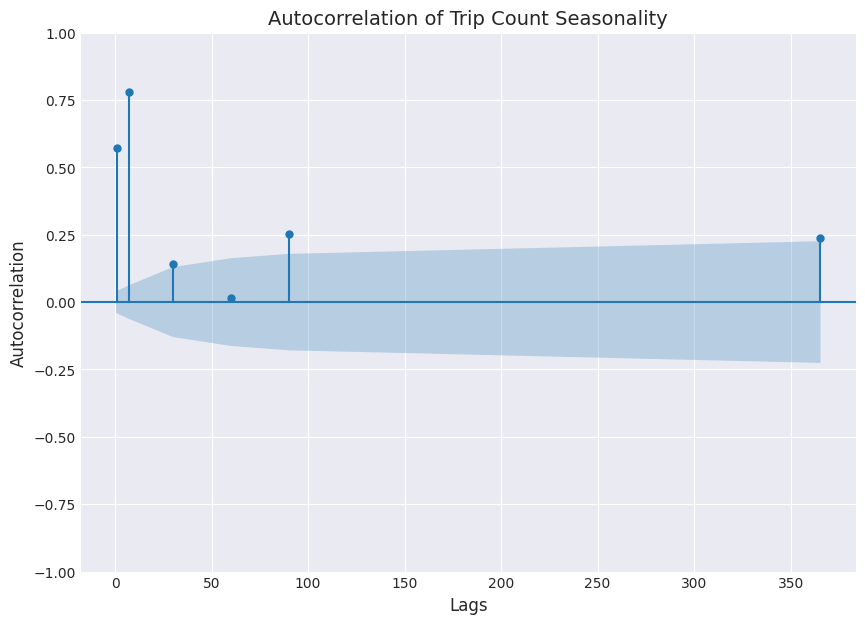

In [12]:
plt.rc("figure", figsize=(10, 7))
plot_acf(df['COUNT'], lags=[1, 7, 30, 60, 90, 365])
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of Trip Count Seasonality', fontsize=14)
plt.show()

As suspected, lags on 1, 7, 90 and 365 days have the strongest positive correlation.

Snowpark has many [functions](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/_autosummary/snowflake.snowpark.functions.html) for things like transformation, statistical analysis, etc. We will use the `lag()` window function to generate lag features very quickly on this very large dataset.
  
NOTE: In addition to the rich set of Snowpark functions, users can also tap into the wealth of [Snowflake built-in functions](https://docs.snowflake.com/en/sql-reference/functions-all.html) using the `call_builtin()` function. 

Here we will generate our features in a function.

In [13]:
def generate_features(snowdf):
    
    snowdf = snowdf.select(F.to_date(F.col('STARTTIME')).alias('DATE'),
                           F.col('START_STATION_ID').alias('STATION_ID'))\
                   .group_by(F.col('STATION_ID'), F.col('DATE'))\
                   .count()
    
    #Impute missing values for lag columns using mean of the previous period.
    mean_1 = round(snowdf.sort('DATE').limit(1).select(F.mean('COUNT')).collect()[0][0])
    mean_7 = round(snowdf.sort('DATE').limit(7).select(F.mean('COUNT')).collect()[0][0])
    mean_90 = round(snowdf.sort('DATE').limit(90).select(F.mean('COUNT')).collect()[0][0])
    mean_365 = round(snowdf.sort('DATE').limit(365).select(F.mean('COUNT')).collect()[0][0])

    date_win = snp.Window.order_by('DATE')

    snowdf = snowdf.with_column('LAG_1', F.lag('COUNT', offset=1, default_value=mean_1) \
                                         .over(date_win)) \
                   .with_column('LAG_7', F.lag('COUNT', offset=7, default_value=mean_7) \
                                         .over(date_win)) \
                   .with_column('LAG_90', F.lag('COUNT', offset=90, default_value=mean_90) \
                                         .over(date_win)) \
                   .with_column('LAG_365', F.lag('COUNT', offset=365, default_value=mean_365) \
                                         .over(date_win)) \
                   .na.drop()
    return snowdf

This function then becomes our feature generation logic and creates essentially a DAG of aggregations and transformations which gets executed _lazily_.

In [14]:
train_snowdf = generate_features(snowdf.filter(F.col('START_STATION_ID') == top_stations[0]))

When we call something this `show()` ALL of the processing gets pushed down into Snowflake compute for highly optimized execution.  In the end the function provides a running list of transformations to build our feature pipeline for inference and training.

In [15]:
train_snowdf.show()

----------------------------------------------------------------------------------
|"STATION_ID"  |"DATE"      |"COUNT"  |"LAG_1"  |"LAG_7"  |"LAG_90"  |"LAG_365"  |
----------------------------------------------------------------------------------
|519           |2013-06-01  |33       |33       |55       |227       |229        |
|519           |2013-06-02  |46       |33       |55       |227       |229        |
|519           |2013-06-03  |41       |46       |55       |227       |229        |
|519           |2013-06-04  |72       |41       |55       |227       |229        |
|519           |2013-06-05  |114      |72       |55       |227       |229        |
|519           |2013-06-06  |68       |114      |55       |227       |229        |
|519           |2013-06-07  |8        |68       |55       |227       |229        |
|519           |2013-06-08  |47       |8        |33       |227       |229        |
|519           |2013-06-09  |69       |47       |46       |227       |229        |
|519

### Baseline
We might start a baseline model with ARIMA.  In this case we get an MSE of something like 56983.  See notebook 02_Data_Science_ARIMA_Baseline.ipynb for details.

Lets try pytorch tabnet to see if we can at least get this level of predictive performance.

### 3. Model Development and Experimentation
We will use [pytorch_tabnet](https://github.com/dreamquark-ai/tabnet) from the 2019 [tabnet paper](https://arxiv.org/pdf/1908.07442.pdf) by Arik, S. O. and Pfister, T.  Tabnet is a powerful deep learning framework for attentive, interpretable learning on tabular data.  Rather than substantial focus on hyper-parameter optimization  we will start with an initial set of hyper-parameters and focus on iterating over input features for now.  
  
Rather than a random split of training/validation data we will split the training dataset using a `cutpoint`.  For example we will save the final 365 days of the dataset as validation and train with the remaining data.

In [16]:
def train(X, y, cutpoint=365, cat_idxs=[], cat_dims=[]):    
    from pytorch_tabnet.tab_model import TabNetRegressor
    import pandas as pd

    X_valid = X[-cutpoint:]
    y_valid = y[-cutpoint:]
    X_train = X[:-cutpoint]
    y_train = y[:-cutpoint]

    max_epochs = 100
    
    batch_df = pd.DataFrame(range(2,65,2), columns=['batch_size'])
    batch_df['batch_remainder'] = len(X_train)%batch_df['batch_size']
    optimal_batch_size=int(batch_df['batch_size'].where(batch_df['batch_remainder']==batch_df['batch_remainder'].min()).max())
    
    print('Selected batch size '+str(optimal_batch_size)+' for input data size: '+str(len(X_train)))
    
    regression_model = TabNetRegressor(cat_idxs=cat_idxs, cat_dims=cat_dims)

    regression_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        max_epochs=max_epochs,
        patience=10,
        batch_size=optimal_batch_size, 
        virtual_batch_size=optimal_batch_size/2,
        num_workers=0,
        drop_last=True)
    
    return regression_model

def predict(model, X):
    y_hat = model.predict(X).reshape(-1)
    return y_hat

def forecast(df, model, lag_values:list, steps:int):
    from datetime import timedelta
    import numpy as np
    forecast_df=df.copy()
    for i in range(steps):
        station_id = forecast_df['STATION_ID'][-1:].values[0]
        future_date = forecast_df['DATE'][-1:].values[0]+timedelta(days=1)
        lags=[forecast_df['COUNT'].shift(i-1)[-1:].values[0] for i in lag_values]
        pred=round(model.predict(np.array([lags]))[0][0])
        row=[*[station_id, future_date, pred], *lags, pred]
        forecast_df.loc[len(forecast_df)]=row
    
    return forecast_df

def plot(df, x_lab:str, y_true_lab:str, y_pred_lab:str):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(15, 8))
    df = pd.melt(df, id_vars=[x_lab], value_vars=[y_true_lab, y_pred_lab])
    ax = sns.lineplot(x=x_lab, y='value', hue='variable', data=df)

We will create a pandas dataframe using to_pandas() which will generate the features as a pyarrow dataset and efficiently read them into memory in pandas locally.  
  
Let's train our first model to get a baseline. 

In [17]:
def train_predict(df, cat_idxs=[], cat_dims=[], lag_values=[], forecast_steps=None):
    import pandas as pd
    from sklearn.metrics import mean_squared_error

    target = ['COUNT']
    feature_columns = [feature.replace('\"', '') for feature in df.columns]
    feature_columns.remove(target[0])
    feature_columns.remove('DATE')
    feature_columns.remove('STATION_ID')

    model = train(df[feature_columns].astype(float).values, 
                  df[target].values,
                  cat_idxs=cat_idxs, 
                  cat_dims=cat_dims)
    df['Y_PRED'] = predict(model, df[feature_columns].astype(float).values).astype('int')
    
    if isinstance(forecast_steps, int):
        df = forecast(df, model, lag_values=lag_values, steps=forecast_steps)

    explain_df = pd.DataFrame(model.explain(df[feature_columns].astype(float).values)[0], 
                         columns = feature_columns).add_prefix('EXPL_').round(2)
    df = pd.concat([df.set_index('DATE').reset_index(), explain_df], axis=1)
    
    MSE = mean_squared_error(y_pred=df['Y_PRED'], y_true=df[target])
    display("Error for training dataset is: "+str(MSE))
    return df.reset_index(drop=True), model, feature_columns

In [18]:
df = train_snowdf.sort('DATE', ascending=True).to_pandas()
df, model, feature_columns = train_predict(df, lag_values=[1,7,90,365], forecast_steps=7)

Selected batch size 52 for input data size: 2028
Device used : cpu
epoch 0  | loss: 167206.99119| val_0_mse: 138724.78903|  0:00:00s
epoch 1  | loss: 126058.01783| val_0_mse: 53395.59252|  0:00:01s
epoch 2  | loss: 63938.0319| val_0_mse: 27203.60386|  0:00:02s
epoch 3  | loss: 26435.96297| val_0_mse: 27301.71615|  0:00:03s
epoch 4  | loss: 19372.7348| val_0_mse: 36342.62629|  0:00:03s
epoch 5  | loss: 19292.72922| val_0_mse: 26229.89818|  0:00:04s
epoch 6  | loss: 18354.92949| val_0_mse: 25120.55299|  0:00:05s
epoch 7  | loss: 17680.30202| val_0_mse: 24203.2958|  0:00:06s
epoch 8  | loss: 17926.34932| val_0_mse: 25167.02002|  0:00:06s
epoch 9  | loss: 17537.84668| val_0_mse: 24578.48589|  0:00:07s
epoch 10 | loss: 18166.43389| val_0_mse: 26003.53517|  0:00:08s
epoch 11 | loss: 18524.35231| val_0_mse: 24210.71454|  0:00:08s
epoch 12 | loss: 17546.33008| val_0_mse: 23863.86691|  0:00:09s
epoch 13 | loss: 17403.36957| val_0_mse: 24411.22104|  0:00:10s
epoch 14 | loss: 17834.37099| val_0_m

'Error for training dataset is: 17391.275'

In [19]:
df

,DATE,STATION_ID,COUNT,LAG_1,LAG_7,LAG_90,LAG_365,Y_PRED,EXPL_LAG_1,EXPL_LAG_7,EXPL_LAG_90,EXPL_LAG_365
0,2013-06-01,519,33,33,55.0,227.0,229.0,93,15.26,11.48,0.0,4.21
1,2013-06-02,519,46,33,55.0,227.0,229.0,93,15.26,11.48,0.0,4.21
2,2013-06-03,519,41,46,55.0,227.0,229.0,97,16.47,11.43,0.0,4.17
3,2013-06-04,519,72,41,55.0,227.0,229.0,95,16.02,11.45,0.0,4.19
4,2013-06-05,519,114,72,55.0,227.0,229.0,102,18.47,11.22,0.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2020-01-03,519,284,252,249.0,244.0,479.0,284,33.94,43.12,0.0,7.75
2396,2020-01-04,519,160,284,99.0,219.0,402.0,160,34.87,13.20,0.0,2.70
2397,2020-01-05,519,192,160,53.0,730.0,51.0,192,27.34,24.99,0.0,8.69
2398,2020-01-06,519,240,192,93.0,725.0,99.0,240,30.39,28.83,0.0,15.54


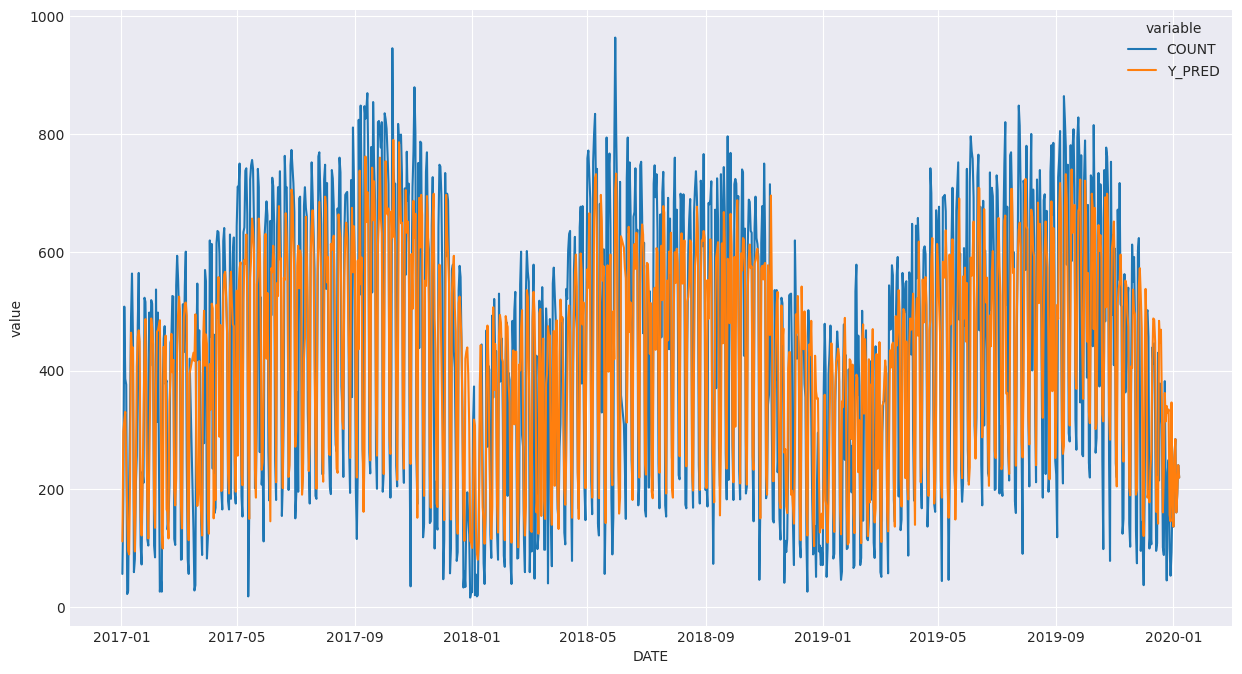

In [20]:
plot(df[-1095:], 'DATE', 'COUNT', 'Y_PRED')

#### What if we add US holidays as a feature?
Pandas has great support for holiday lists.  We can generate a pandas dataframe and then upload it as a temporary table to create a new feature.

In [21]:
def generate_holiday_df(session):
    from snowflake.snowpark import functions as F 
    import pandas as pd
    from pandas.tseries.holiday import USFederalHolidayCalendar
    from datetime import timedelta, datetime

    cal = USFederalHolidayCalendar()

    #generate a feature of 20 years worth of US holiday days.
    start_date = datetime.strptime('2013-01-01', '%Y-%m-%d')
    end_date = start_date+timedelta(days=365*20)

    holiday_df = pd.DataFrame(cal.holidays(start=start_date, end=end_date), columns=['DATE'])
    holiday_df['DATE'] = holiday_df['DATE'].dt.strftime('%Y-%m-%d')

    session.create_dataframe(holiday_df) \
           .with_column("HOLIDAY", F.lit(1))\
           .write\
           .save_as_table("HOLIDAYS", mode="overwrite", table_type="temporary")
    
    return session.table("HOLIDAYS")

In [22]:
holiday_df = generate_holiday_df(session)
holiday_df.show()

create_temp_table is deprecated. We still respect this parameter when it is True but please consider using `table_type="temporary"` instead.


--------------------------
|"DATE"      |"HOLIDAY"  |
--------------------------
|2013-01-01  |1          |
|2013-01-21  |1          |
|2013-02-18  |1          |
|2013-05-27  |1          |
|2013-07-04  |1          |
|2013-09-02  |1          |
|2013-10-14  |1          |
|2013-11-11  |1          |
|2013-11-28  |1          |
|2013-12-25  |1          |
--------------------------



Here we create an in-memory instance of the holiday dataframe.  In production we probably want to materialize this feature as a table or view.  We'll see later how that is easy to do but for now we have a function to generate it and join it to our training dataframe as a one-hot feature.

Every time we join there is a possibility of losing data from our feature set if the join column doesn't cover the same dates.  So its good to check.

In [23]:
train_snowdf = train_snowdf.join(holiday_df, 'DATE', join_type='left') \
                           .na.fill({'HOLIDAY':0}) \
                           .sort('DATE', ascending=True)
train_snowdf.show()

----------------------------------------------------------------------------------------------
|"DATE"      |"STATION_ID"  |"COUNT"  |"LAG_1"  |"LAG_7"  |"LAG_90"  |"LAG_365"  |"HOLIDAY"  |
----------------------------------------------------------------------------------------------
|2013-06-01  |519           |33       |33       |55       |227       |229        |0          |
|2013-06-02  |519           |46       |33       |55       |227       |229        |0          |
|2013-06-03  |519           |41       |46       |55       |227       |229        |0          |
|2013-06-04  |519           |72       |41       |55       |227       |229        |0          |
|2013-06-05  |519           |114      |72       |55       |227       |229        |0          |
|2013-06-06  |519           |68       |114      |55       |227       |229        |0          |
|2013-06-07  |519           |8        |68       |55       |227       |229        |0          |
|2013-06-08  |519           |47       |8        |3

Now when we train we need to specify this new holiday feature as a categorical feature.  Its already encoded (by definition) so nothing to add there.

In [24]:
df = train_snowdf.sort('DATE', ascending=True).to_pandas()
df, model, feature_columns = train_predict(df, cat_idxs=[-1], cat_dims=[2])

Selected batch size 52 for input data size: 2028
Device used : cpu
epoch 0  | loss: 164735.28245| val_0_mse: 119092.10224|  0:00:01s
epoch 1  | loss: 123780.90104| val_0_mse: 73564.99294|  0:00:02s
epoch 2  | loss: 65430.85306| val_0_mse: 37004.2513|  0:00:03s
epoch 3  | loss: 28068.60129| val_0_mse: 30458.52817|  0:00:04s
epoch 4  | loss: 19610.41486| val_0_mse: 25748.28589|  0:00:04s
epoch 5  | loss: 18908.28504| val_0_mse: 22694.09901|  0:00:05s
epoch 6  | loss: 17756.80754| val_0_mse: 23282.78632|  0:00:06s
epoch 7  | loss: 18506.30479| val_0_mse: 23290.42577|  0:00:07s
epoch 8  | loss: 17877.45792| val_0_mse: 24089.73627|  0:00:08s
epoch 9  | loss: 17312.48187| val_0_mse: 23451.99529|  0:00:09s
epoch 10 | loss: 17760.6624| val_0_mse: 23565.81697|  0:00:10s
epoch 11 | loss: 17336.73743| val_0_mse: 21827.03002|  0:00:11s
epoch 12 | loss: 17087.65192| val_0_mse: 22426.16652|  0:00:11s
epoch 13 | loss: 17667.56626| val_0_mse: 22183.48706|  0:00:12s
epoch 14 | loss: 17338.32632| val_0_

'Error for training dataset is: 16597.137484329294'

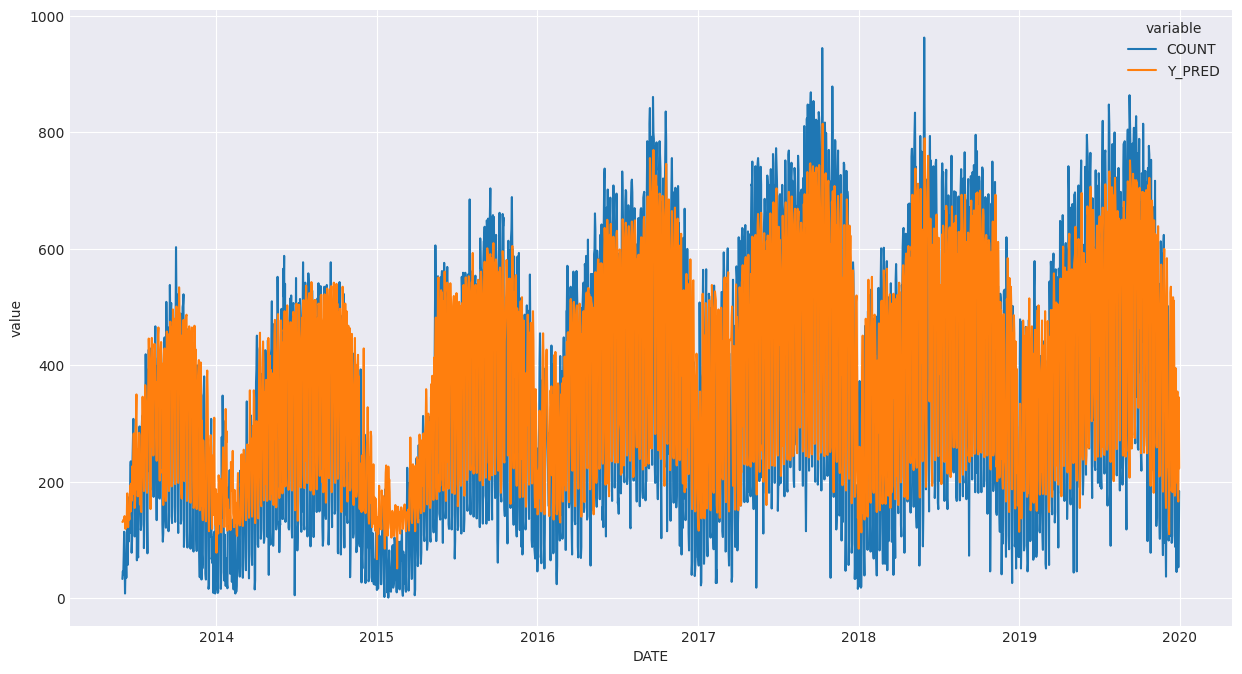

In [25]:
plot(df, 'DATE', 'COUNT', 'Y_PRED')

#### Enhancing Model Accuracy With Weather Data

Let's see how we can make our model even better with weather data. Its likely that weather and the amount of precipitation on the day will be an important signal for our model. 
  
We might start by downloading weather data or setting up an API.  But this is a lot of work when we want to build inference pipelines later.

In [26]:
# def generate_weather_df(session):
#     from snowflake.snowpark import Window
#     from snowflake.snowpark import functions as F 
#     import pandas as pd

#     tempdf = pd.read_csv('./include/weather.csv')
#     tempdf['DATE']=pd.to_datetime(tempdf['dt_iso'].str.replace(' UTC', ''), 
#                                  format='%Y-%m-%d %H:%M:%S %z', 
#                                  utc=True).dt.tz_convert('America/New_York').dt.date
#     tempdf.columns=tempdf.columns.str.upper()
        
#     session.create_dataframe(tempdf[['DATE','RAIN_1H', 'TEMP']]) \
#            .group_by('DATE').agg([F.round(F.mean('RAIN_1H'), 2).alias('PRECIP'),
#                                  F.round(F.mean('TEMP')-F.lit(273.15), 2).alias('TEMP')])\
#            .fillna({'PRECIP':0, 'TEMP':0})\
#            .write\
#            .save_as_table("WEATHER", mode="overwrite", create_temp_table=True)

#     return session.table('WEATHER')

# weather_df = generate_weather_df(session)
# weather_df.show()
# weather_df.select(F.min('DATE'), F.max('DATE')).show()

####  Use the [Snowflake Data Marketplace](https://www.snowflake.com/data-marketplace/?_sft_dataset-category=weather)  
The Snowflake marketplace allows us to very easily access weather data (among many other types of data) and join it with the trips data.  Not only is this faster and more scalable than building from a csv file or an API, it is extremely easy to setup an MLops pipeline to keep it fresh.  
  
For this demo we will use a dataset from [Weather Source](https://app.snowflake.com/marketplace/listing/GZSOZ1LLE9).  
  
Weather Source is a leading provider of global weather and climate data and our OnPoint Product Suite provides businesses with the necessary weather and climate data to quickly generate meaningful and actionable insights for a wide range of use cases across industries.

**See notebook 02_Data_Marketplace.ipynb for details on accessing this data**.

Alternatively, run the following to subscribe.

In [27]:
weather_listing_id = state_dict['weather_listing_id']
weather_database_name = state_dict['weather_database_name']

session.sql("CREATE OR REPLACE DATABASE "+weather_database_name+" FROM SHARE "+weather_listing_id).collect()

#The default database and schema may be reset after creating a new database
session.use_database(state_dict['connection_parameters']['database'])
session.use_schema(state_dict['connection_parameters']['schema'])

In [28]:
def generate_weather_df(session, weather_table_name):

    weather_df = session.table(weather_table_name)\
                       .filter(F.col('POSTAL_CODE') == '10007')\
                       .select(F.col('DATE_VALID_STD').alias('DATE'), 
                               F.col('TOT_PRECIPITATION_MM').alias('PRECIP'), 
                               F.round(F.col('AVG_TEMPERATURE_FEELSLIKE_2M_C'), 2).alias('TEMP'))\
                       .sort('DATE', ascending=True)
    return weather_df

In [29]:
weather_table_name = weather_database_name+'.ONPOINT_ID.HISTORY_DAY'

weather_df = generate_weather_df(session, weather_table_name)
weather_df.show()
weather_df.select(F.min('DATE'), F.max('DATE')).show()

----------------------------------
|"DATE"      |"PRECIP"  |"TEMP"  |
----------------------------------
|2013-06-01  |0.0       |22.5    |
|2013-06-02  |13.3      |22.2    |
|2013-06-03  |13.7      |19.7    |
|2013-06-04  |0.0       |18.2    |
|2013-06-05  |0.8       |17.3    |
|2013-06-06  |6.0       |16.3    |
|2013-06-07  |81.8      |15.5    |
|2013-06-08  |4.6       |18.6    |
|2013-06-09  |0.0       |20.6    |
|2013-06-10  |27.1      |18.2    |
----------------------------------

-------------------------------------
|"MIN(""DATE"")"  |"MAX(""DATE"")"  |
-------------------------------------
|2013-06-01       |2022-11-23       |
-------------------------------------



We add weather features by joining the weather dataframe.

In [30]:
train_snowdf = train_snowdf.join(weather_df, 'DATE', 'inner').sort('DATE', ascending=True)
train_snowdf.show()

------------------------------------------------------------------------------------------------------------------
|"DATE"      |"STATION_ID"  |"COUNT"  |"LAG_1"  |"LAG_7"  |"LAG_90"  |"LAG_365"  |"HOLIDAY"  |"PRECIP"  |"TEMP"  |
------------------------------------------------------------------------------------------------------------------
|2013-06-01  |519           |33       |33       |55       |227       |229        |0          |0.0       |22.5    |
|2013-06-02  |519           |46       |33       |55       |227       |229        |0          |13.3      |22.2    |
|2013-06-03  |519           |41       |46       |55       |227       |229        |0          |13.7      |19.7    |
|2013-06-04  |519           |72       |41       |55       |227       |229        |0          |0.0       |18.2    |
|2013-06-05  |519           |114      |72       |55       |227       |229        |0          |0.8       |17.3    |
|2013-06-06  |519           |68       |114      |55       |227       |229       

Again, check the date range after the join.

In [31]:
train_snowdf.select(F.min('DATE'), F.max('DATE')).show()

-------------------------------------
|"MIN(""DATE"")"  |"MAX(""DATE"")"  |
-------------------------------------
|2013-06-01       |2019-12-31       |
-------------------------------------



In [32]:
df = train_snowdf.sort('DATE', ascending=True).to_pandas()
df, model, feature_columns = train_predict(df, cat_idxs=[-3], cat_dims=[2])

Selected batch size 52 for input data size: 2028
Device used : cpu
epoch 0  | loss: 167160.32452| val_0_mse: 118339.83377|  0:00:01s
epoch 1  | loss: 128137.32452| val_0_mse: 66429.51785|  0:00:01s
epoch 2  | loss: 65955.20453| val_0_mse: 26421.24712|  0:00:02s
epoch 3  | loss: 24577.02396| val_0_mse: 27832.07256|  0:00:03s
epoch 4  | loss: 16617.86025| val_0_mse: 19511.42935|  0:00:04s
epoch 5  | loss: 14986.53706| val_0_mse: 18813.51205|  0:00:04s
epoch 6  | loss: 15513.70267| val_0_mse: 17732.54533|  0:00:05s
epoch 7  | loss: 15040.65818| val_0_mse: 18882.12387|  0:00:06s
epoch 8  | loss: 14560.5995| val_0_mse: 17518.64668|  0:00:07s
epoch 9  | loss: 14867.78498| val_0_mse: 17839.53051|  0:00:07s
epoch 10 | loss: 13855.87184| val_0_mse: 17737.56038|  0:00:08s
epoch 11 | loss: 14566.03657| val_0_mse: 18528.75474|  0:00:09s
epoch 12 | loss: 13628.07809| val_0_mse: 16887.2127|  0:00:10s
epoch 13 | loss: 13432.67554| val_0_mse: 17187.4274|  0:00:10s
epoch 14 | loss: 14052.0804| val_0_ms

'Error for training dataset is: 11875.272043460092'

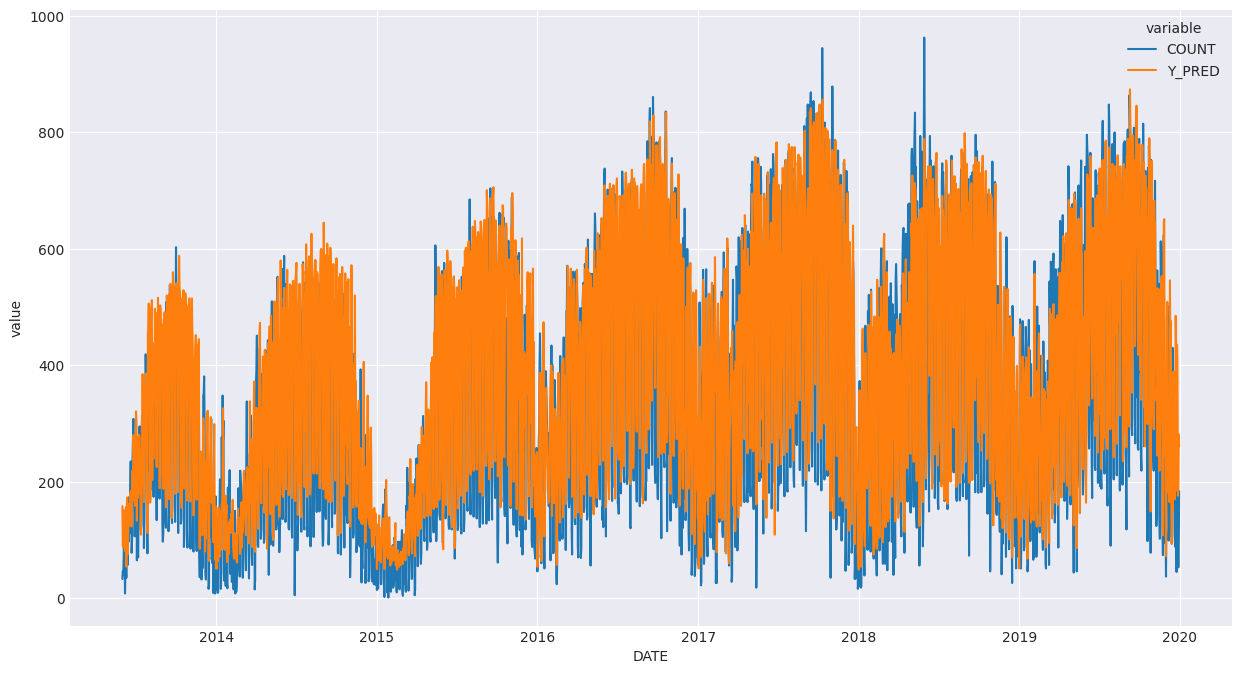

In [33]:
plot(df, 'DATE', 'COUNT', 'Y_PRED')

#### Lets look at the feature importance
One reason we chose tabnet for this analysis is the built-in abilities for explainability.

In [34]:
pd.DataFrame([model.feature_importances_], columns=feature_columns)

,LAG_1,LAG_7,LAG_90,LAG_365,HOLIDAY,PRECIP,TEMP
0,0.009432,0.388072,0.127294,0.0,0.008954,0.302841,0.163408


In [35]:
state_dict['holiday_table_name'] = 'HOLIDAYS'
state_dict['weather_database_name'] = 'WEATHER_NYC'
state_dict['weather_table_name'] = state_dict['weather_database_name']+'.ONPOINT_ID.HISTORY_DAY'

import json
with open('./include/state.json', 'w') as sdf:
    json.dump(state_dict, sdf)

session.close()

#### Lets consolidate and upate our feature functions and save them for the ML engineering team to operationalize.
Based on the feature importance above we will go with 1 and 7 day lags only.

In [36]:
%%writefile dags/feature_engineering.py

def generate_holiday_df(session, holiday_table_name:str):
    from snowflake.snowpark import functions as F 
    import pandas as pd
    from pandas.tseries.holiday import USFederalHolidayCalendar
    from datetime import timedelta, datetime

    cal = USFederalHolidayCalendar()

    #generate a feature of 20 years worth of US holiday days.
    start_date = datetime.strptime('2013-01-01', '%Y-%m-%d')
    end_date = start_date+timedelta(days=365*20)

    holiday_df = pd.DataFrame(cal.holidays(start=start_date, end=end_date), columns=['DATE'])
    holiday_df['DATE'] = holiday_df['DATE'].dt.strftime('%Y-%m-%d')

    session.create_dataframe(holiday_df) \
           .with_column("HOLIDAY", F.lit(1))\
           .write\
           .save_as_table(holiday_table_name, mode="overwrite", table_type="temporary")
    
    return session.table(holiday_table_name)

def generate_weather_df(session, weather_table_name):
    from snowflake.snowpark import functions as F 
    return session.table(weather_table_name)\
                  .filter(F.col('POSTAL_CODE') == '10007')\
                  .select(F.col('DATE_VALID_STD').alias('DATE'), 
                          F.col('TOT_PRECIPITATION_MM').alias('PRECIP'), 
                          F.round(F.col('AVG_TEMPERATURE_FEELSLIKE_2M_C'), 2).alias('TEMP'))\
                  .sort('DATE', ascending=True)

def generate_features(session, input_df, holiday_table_name, weather_table_name):
    import snowflake.snowpark as snp
    from snowflake.snowpark import functions as F 
    
    #start_date, end_date = input_df.select(F.min('STARTTIME'), F.max('STARTTIME')).collect()[0][0:2]
    
    #check if features are already materialized (or in a temp table)
    holiday_df = session.table(holiday_table_name)
    try: 
        _ = holiday_df.columns
    except:
        holiday_df = generate_holiday_df(session, holiday_table_name)
        
    weather_df = session.table(weather_table_name)[['DATE','TEMP']]
    try: 
        _ = weather_df.columns
    except:
        weather_df = generate_weather_df(session, weather_table_name)[['DATE','PRECIP','TEMP']]

    feature_df = input_df.select(F.to_date(F.col('STARTTIME')).alias('DATE'),
                                 F.col('START_STATION_ID').alias('STATION_ID'))\
                         .replace({'NULL': None}, subset=['STATION_ID'])\
                         .group_by(F.col('STATION_ID'), F.col('DATE'))\
                         .count()

    #Impute missing values for lag columns using mean of the previous period.
    mean_1 = round(feature_df.sort('DATE').limit(1).select(F.mean('COUNT')).collect()[0][0])
    mean_7 = round(feature_df.sort('DATE').limit(7).select(F.mean('COUNT')).collect()[0][0])
    mean_90 = round(feature_df.sort('DATE').limit(90).select(F.mean('COUNT')).collect()[0][0])
    mean_365 = round(feature_df.sort('DATE').limit(365).select(F.mean('COUNT')).collect()[0][0])

    date_win = snp.Window.order_by('DATE')

    feature_df = feature_df.with_column('LAG_1', F.lag('COUNT', offset=1, default_value=mean_1) \
                                         .over(date_win)) \
                           .with_column('LAG_7', F.lag('COUNT', offset=7, default_value=mean_7) \
                                         .over(date_win)) \
                           .with_column('LAG_90', F.lag('COUNT', offset=90, default_value=mean_90) \
                                         .over(date_win)) \
                           .with_column('LAG_365', F.lag('COUNT', offset=365, default_value=mean_365) \
                                         .over(date_win)) \
                           .join(holiday_df, 'DATE', join_type='left').na.fill({'HOLIDAY':0}) \
                           .join(weather_df, 'DATE', 'inner') \
                          .na.drop() 

    return feature_df

Overwriting dags/feature_engineering.py


Finally, train and evaluate the model with the final feature set.

In [37]:
from dags.snowpark_connection import snowpark_connect
from dags.feature_engineering import generate_features
from snowflake.snowpark import functions as F
import pandas as pd

session, state_dict = snowpark_connect()
test_station_id = '519'

snowdf = session.table(state_dict['trips_table_name']).filter(F.col('START_STATION_ID') == test_station_id)

train_snowdf = generate_features(session=session, 
                                 input_df=snowdf, 
                                 holiday_table_name=state_dict['holiday_table_name'], 
                                 weather_table_name=state_dict['weather_table_name'])

df = train_snowdf.sort('DATE', ascending=True).to_pandas()
df, model, feature_columns = train_predict(df, cat_idxs=[-3], cat_dims=[2])

Selected batch size 52 for input data size: 2028
Device used : cpu
epoch 0  | loss: 167160.32452| val_0_mse: 118339.83377|  0:00:00s
epoch 1  | loss: 128137.32452| val_0_mse: 66429.51785|  0:00:01s
epoch 2  | loss: 65955.20453| val_0_mse: 26421.24712|  0:00:02s
epoch 3  | loss: 24577.02396| val_0_mse: 27832.07256|  0:00:03s
epoch 4  | loss: 16617.86025| val_0_mse: 19511.42935|  0:00:03s
epoch 5  | loss: 14986.53706| val_0_mse: 18813.51205|  0:00:04s
epoch 6  | loss: 15513.70267| val_0_mse: 17732.54533|  0:00:05s
epoch 7  | loss: 15040.65818| val_0_mse: 18882.12387|  0:00:06s
epoch 8  | loss: 14560.5995| val_0_mse: 17518.64668|  0:00:06s
epoch 9  | loss: 14867.78498| val_0_mse: 17839.53051|  0:00:07s
epoch 10 | loss: 13855.87184| val_0_mse: 17737.56038|  0:00:08s
epoch 11 | loss: 14566.03657| val_0_mse: 18528.75474|  0:00:09s
epoch 12 | loss: 13628.07809| val_0_mse: 16887.2127|  0:00:09s
epoch 13 | loss: 13432.67554| val_0_mse: 17187.4274|  0:00:10s
epoch 14 | loss: 14052.0804| val_0_ms

'Error for training dataset is: 11875.272043460092'

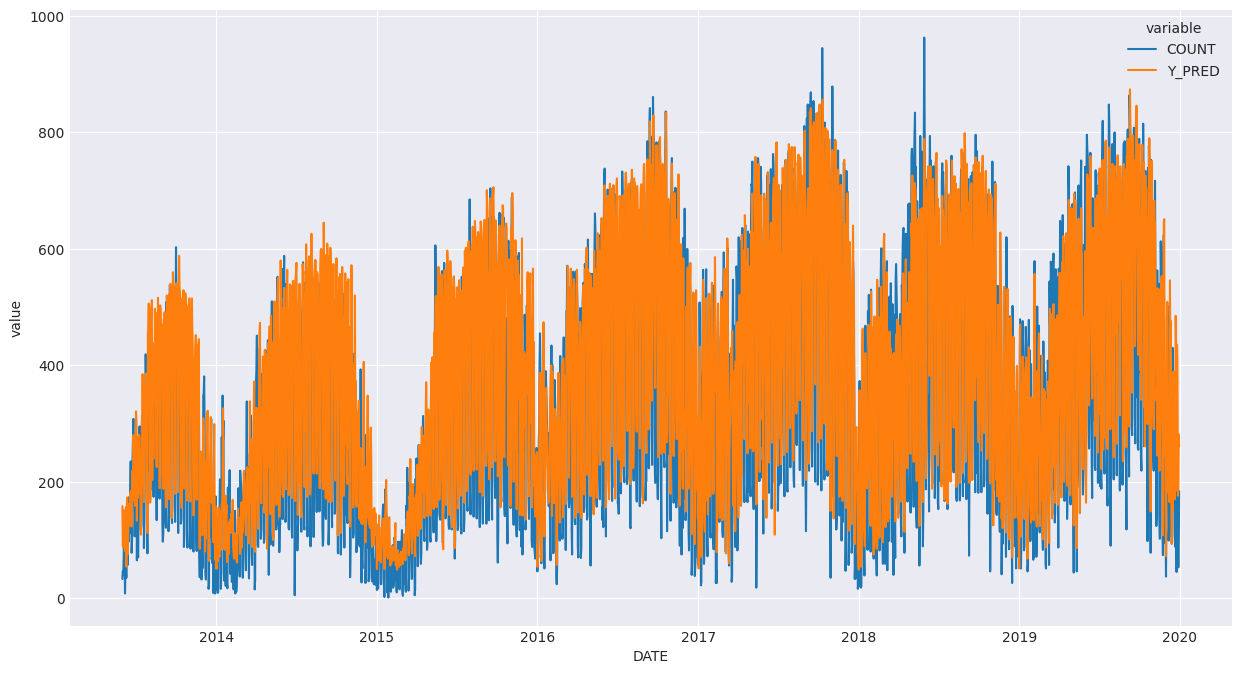

In [38]:
plot(df, 'DATE', 'COUNT', 'Y_PRED')

In [39]:
pd.DataFrame([model.feature_importances_], columns=feature_columns)

,LAG_1,LAG_7,LAG_90,LAG_365,HOLIDAY,PRECIP,TEMP
0,0.009432,0.388072,0.127294,0.0,0.008954,0.302841,0.163408


In [40]:
session.close()